In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import theano
import theano.tensor as tt 
from plotting import *
print(theano.config.device)

np.random.seed(42)
pm.set_tt_rng(42)


Loaded configuration file /lila/home/harrigan/.local/share/jupyter/runtime/kernel-b8b23b38-89ac-4585-99fa-44cb03094a46.json
cpu


Generate Data

In [2]:
C = 32
M = 3
J = 3
K = 3
N = np.array([10000] * 20)
S = len(N)

# Hyper-parameter for priors
alpha = np.ones(C) * 0.05
psi = np.ones(J)
gamma = np.ones(K) * 0.1
beta = np.ones((K,4)) * 0.1

# cosmic signatures => no generative phi/eta
# use tau_act for activities
tau = pd.read_csv('~/data/cosmic/sigProfiler_SBS_signatures_2019_05_22.csv', index_col = [0,1]).to_numpy().T[[3, 12, 20]]
I = tau.shape[0]
tau_activities = pm.Dirichlet.dist(a=np.ones(I) * 0.1).random(size = S)

In [3]:
tau_activities.round(2)

array([[0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.03, 0.97, 0.  ],
       [0.07, 0.  , 0.93],
       [0.01, 0.  , 0.99],
       [0.  , 1.  , 0.  ],
       [0.  , 0.13, 0.87],
       [0.  , 0.67, 0.33],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.29, 0.71],
       [0.  , 1.  , 0.  ],
       [0.  , 0.12, 0.88],
       [0.  , 0.47, 0.53],
       [1.  , 0.  , 0.  ],
       [0.06, 0.93, 0.  ],
       [0.  , 0.98, 0.02],
       [0.2 , 0.58, 0.21]])

In [4]:
B=(tau_activities @ tau)
data = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, B)])

Preview simulated signatures

In [5]:
mut96 = ['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 
         'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 
         'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 
         'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 
         'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 
         'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 
         'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 
         'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 
         'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 
         'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 
         'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 
         'G[T>G]A', 'G[T>G]C', 'G[T>G]G', 'G[T>G]T', 'T[T>G]A', 'T[T>G]C', 'T[T>G]G', 'T[T>G]T']


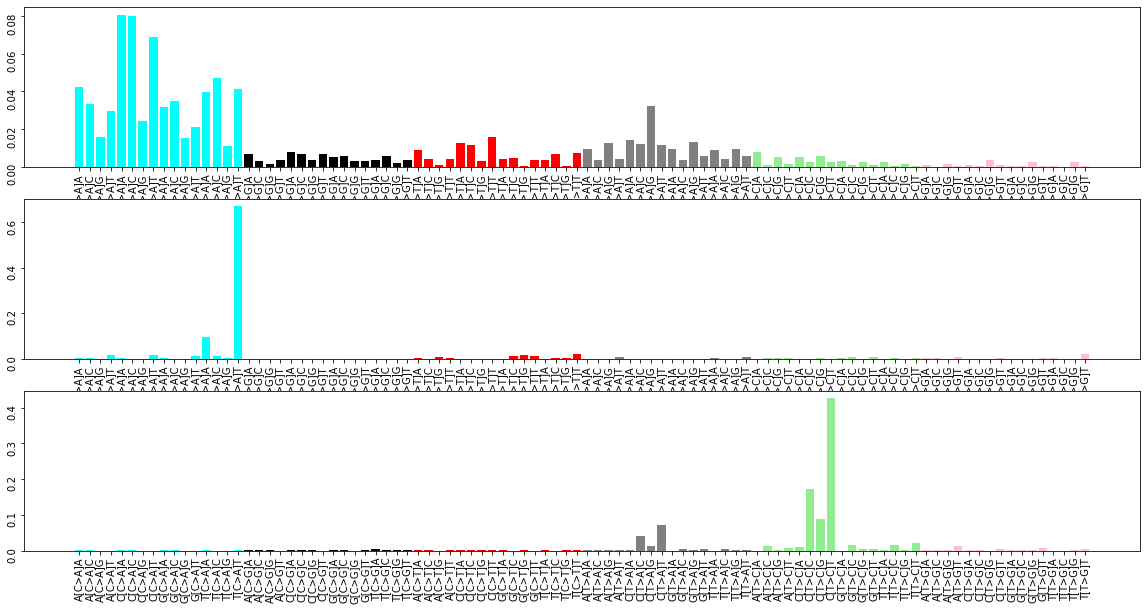

In [6]:
plt.figure(figsize=(20,10))
l=0
for i in range(I):
    l += 1
    plt.subplot(I,1,l)
    plt.bar(mut96, tau[i], color=np.repeat(['cyan', 'black', 'red', 'grey', 'lightgreen', 'pink'], 16))
    plt.tick_params(labelsize=10, rotation=90)

In [7]:
def get_phis(sigs):
    # for each signature in sigs, get the corresponding phi
    wrapped = sigs.reshape(sigs.shape[0], -1, 16)
    phis = np.hstack([wrapped[:,[0,1,2],:].sum(1), wrapped[:,[3,4,5],:].sum(1)])
    return phis

def get_etas(sigs):
    # for each signature in sigs, get the corresponding eta
    # ordered alphabetically, or pyrimidine last (?)
    wrapped = sigs.reshape(sigs.shape[0], -1, 16)
    etas = wrapped.sum(2)
    return etas#[0,1,2,3,5,4]

def top_k():
    # find the top k most dissimilar signatures
    # use clark method
    return None

In [8]:
tt.printing.Print()(np.exp(pm.Normal.dist().logp(1)))

Print{message='', attrs=('__str__',), global_fn=<function _print_fn at 0x7f12bc5cb4c0>}.0

In [9]:
get_etas(tau).shape

(3, 6)

In [10]:
np.stack([get_etas(tau)] * 16).shape

(16, 3, 6)

## 'collapsed' two step LDA

In [11]:
with pm.Model() as collapsed_model:

    phi = pm.Dirichlet('phi', a=alpha, shape=(J, C))
    theta = pm.Dirichlet("theta", a=psi, shape=(S, J))
    A = pm.Dirichlet("A", a=gamma, shape = (S, J, K))
    etaC = pm.Dirichlet("etaC", a=beta[:,[0,2,3]], shape=(C//2, K, M))
    etaT = pm.Dirichlet("etaT", a=beta[:,[0,1,2]], shape=(C//2, K, M))
    eta = pm.Deterministic('eta', pm.math.concatenate([etaC, etaT], axis=0))

    B = pm.Deterministic("B", (pm.math.matrix_dot(theta, phi)[:,:,None] * \
                               pm.math.matrix_dot(tt.batched_dot(theta,A),eta)).reshape((S, -1)))
    
    tt.printing.Print('A')(eta.shape)
    
    # mutation counts
    pm.Multinomial('corpus', n = N.reshape(S,1), p = B , observed=data)

A __str__ = [32  3  3]


Fit the model with ADVI

In [12]:
with collapsed_model:
    advi_trace = pm.ADVI()
    advi_trace.fit()
    

Finished [100%]: Average Loss = 1.432e+05


Diagnostic plots

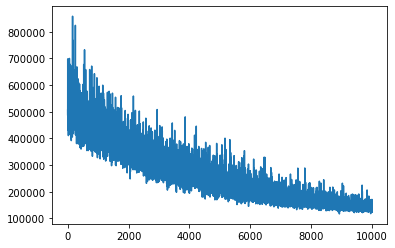

In [13]:
plt.plot(advi_trace.hist);

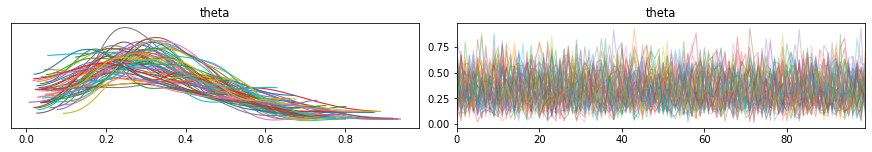

In [14]:
with collapsed_model:
    pm.plot_trace(advi_trace.approx.sample(100), var_names = 'theta');

Finished [100%]: Average Loss = 7,745.1


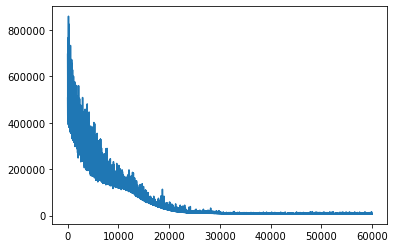

In [15]:
advi_trace.refine(50000)
plt.plot(advi_trace.hist);

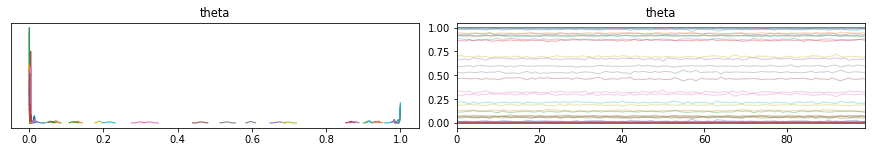

In [16]:
with collapsed_model:
    pm.plot_trace(advi_trace.approx.sample(100), var_names = 'theta');

In [17]:
advi_trace.approx.sample(100)['theta'][1].round(2)

array([[1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.08, 0.91, 0.02],
       [0.98, 0.02, 0.  ],
       [0.01, 0.06, 0.93],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.13, 0.  , 0.86],
       [0.67, 0.  , 0.33],
       [0.08, 0.9 , 0.02],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.31, 0.01, 0.68],
       [1.  , 0.  , 0.  ],
       [0.13, 0.  , 0.87],
       [0.46, 0.  , 0.53],
       [0.07, 0.92, 0.01],
       [0.94, 0.05, 0.  ],
       [0.98, 0.  , 0.02],
       [0.59, 0.18, 0.23]])

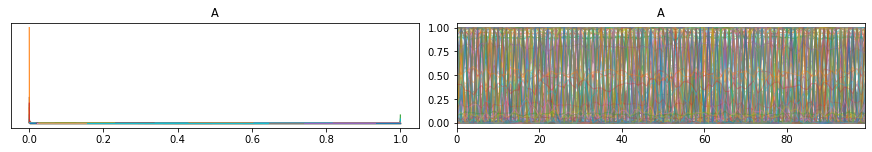

In [18]:
with collapsed_model:
    pm.plot_trace(advi_trace.approx.sample(100), var_names = 'A');
    

/home/harrigan/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


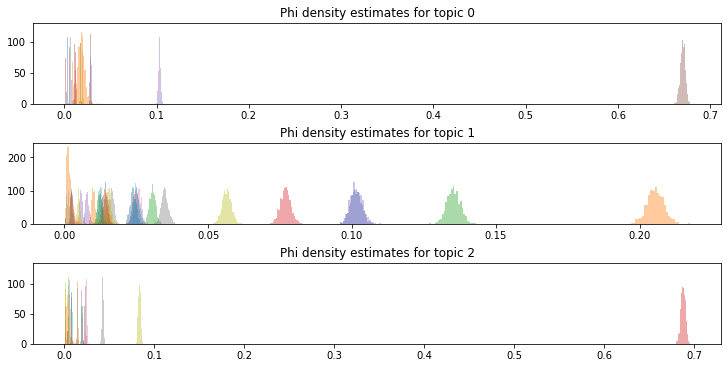

In [19]:
plt.figure(figsize=(10,5), constrained_layout = True)
for j in range(J):
    plt.subplot(J,1,j+1)
    for c in range(C):
        sns.distplot(advi_trace.approx.sample(1000)['phi'][:, j, c], kde=False, hist=True)
    plt.title(f'Phi density estimates for topic {j}')

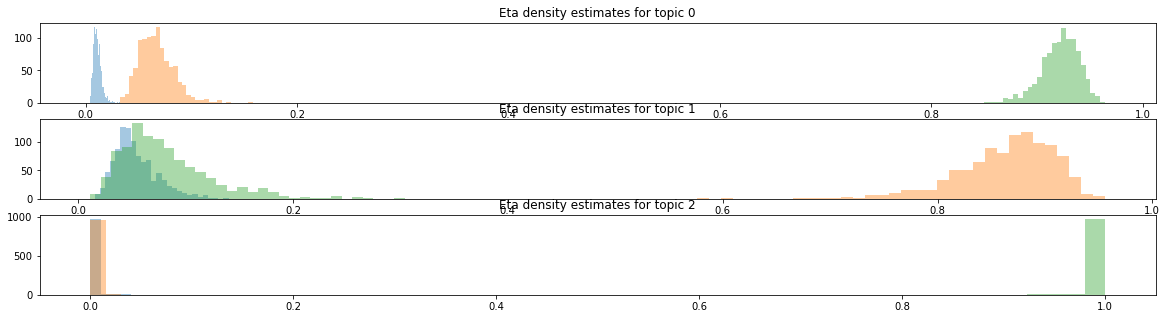

In [20]:
plt.figure(figsize=(20,5))
for k in range(K):
    plt.subplot(K,1,k+1)
    for m in range(M):
        sns.distplot(advi_trace.approx.sample(1000)['eta'][:, 31, k, m], kde=False, hist=True)
    plt.title(f'Eta density estimates for topic {k}')

In [21]:
#with collapsed_model:
#    ppc = pm.sample_posterior_predictive(advi_trace.approx.sample(100))
#    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=collapsed_model));

In [22]:
# requires reorder for Y>A Y>G Y>Y
yy_to_mutsig = np.array([ 0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45,
                         1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 
                         2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 
                         48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 
                         49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 
                         50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95])

In [23]:
A

A ~ Dirichlet

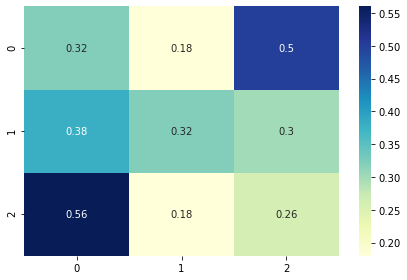

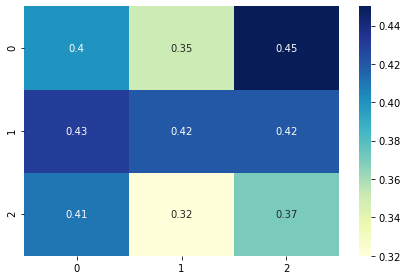

In [24]:
a = advi_trace.approx.sample_node(A, size = 1000).eval()
ax = sns.heatmap(np.round(a.mean((0, 1)), 2), annot=True, cmap="YlGnBu")
plt.tight_layout()
plt.show()
ax = sns.heatmap(np.round(a.std((0, 1)), 2), annot=True, cmap="YlGnBu")
plt.tight_layout()
plt.show()

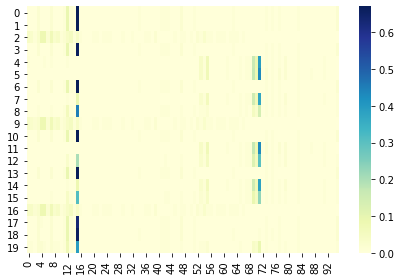

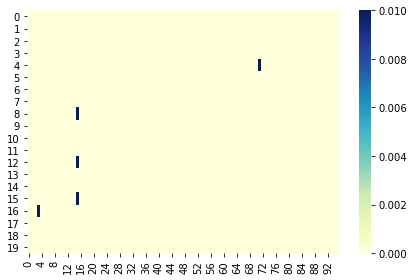

In [26]:
a = advi_trace.approx.sample_node(B, size = 1000).eval()
ax = sns.heatmap(np.round(a.mean((0)), 2), annot=False, cmap="YlGnBu")
plt.tight_layout()
plt.show()
ax = sns.heatmap(np.round(a.std((0)), 2), annot=False, cmap="YlGnBu")
plt.tight_layout()
plt.show()

In [27]:
with collapsed_model:
    
    phi_hat=advi_trace.approx.sample_node(phi).eval()
    eta_hat=advi_trace.approx.sample_node(eta).eval()
    
    sig_hat = np.vstack([np.outer(phi_hat[j,c], eta_hat[c,k,:]) \
                for j in range(J) for k in range(K) for c in range(C)]).reshape(J, K, -1).reshape(-1, 96)
    
    print(sig_hat.shape)
    print(cosine_similarity(sig_hat, tau).round(2))



(9, 96)
[[0.28 1.   0.01]
 [0.3  0.97 0.  ]
 [0.28 1.   0.  ]
 [0.86 0.09 0.07]
 [0.97 0.06 0.03]
 [0.62 0.1  0.03]
 [0.05 0.01 1.  ]
 [0.08 0.01 0.63]
 [0.06 0.01 0.98]]


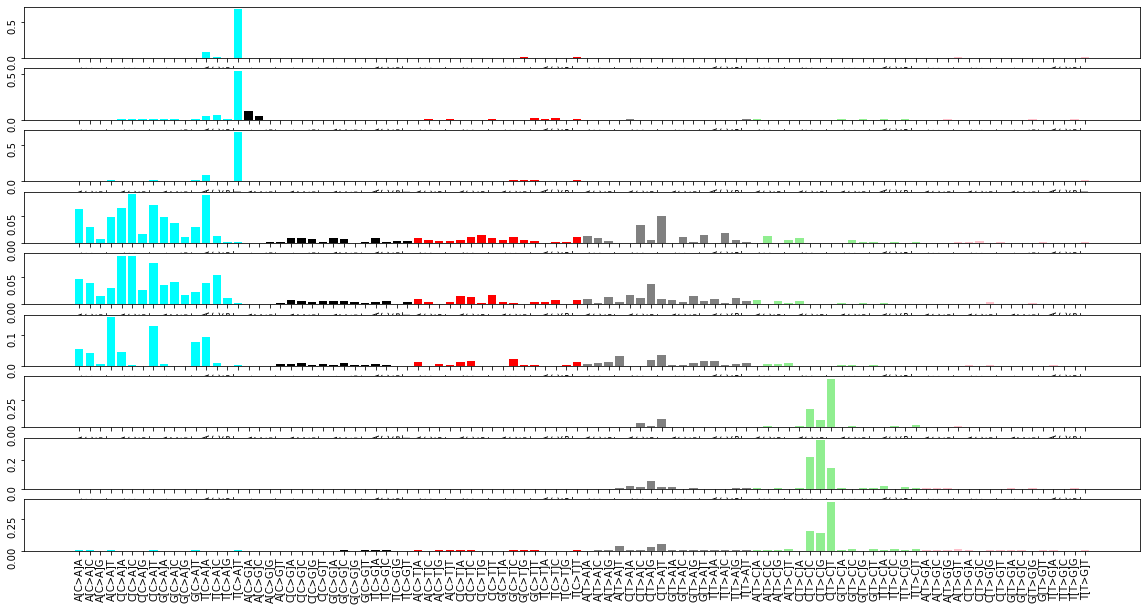

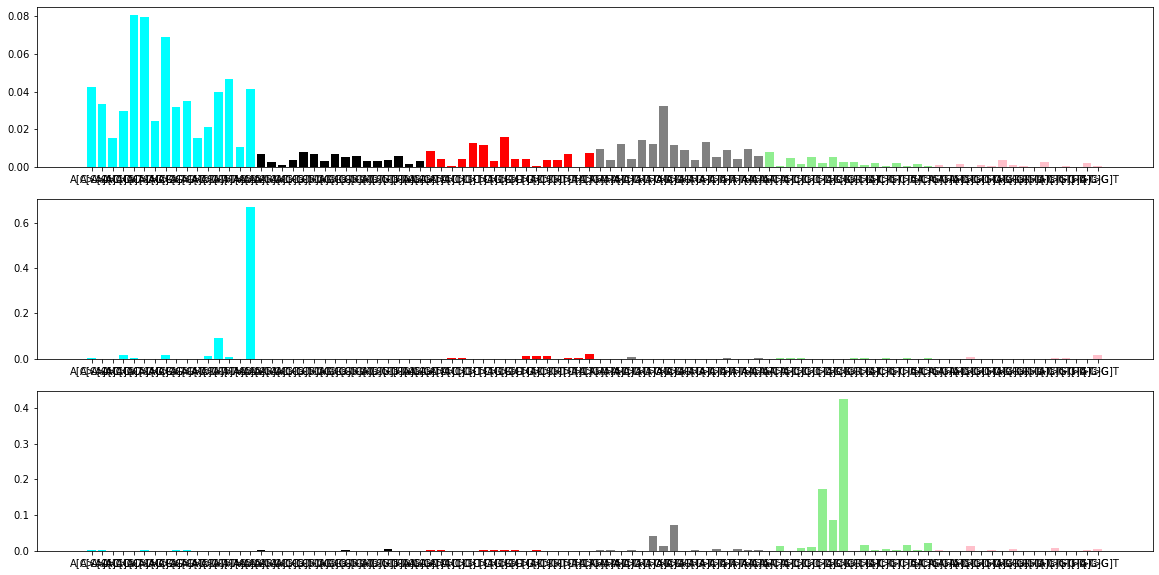

In [28]:
plt.figure(figsize=(20,10))

for i in range(J*K):
    plt.subplot(J*K,1,i+1)
    plt.bar(mut96, sig_hat[i], color=np.repeat(['cyan', 'black', 'red', 'grey', 'lightgreen', 'pink'], 16))
    plt.tick_params(labelsize=10, rotation=90)
    

plt.figure(figsize=(20,10))

for i in range(I):
    plt.subplot(I,1,i+1)
    plt.bar(mut96, tau[i], color=np.repeat(['cyan', 'black', 'red', 'grey', 'lightgreen', 'pink'], 16))

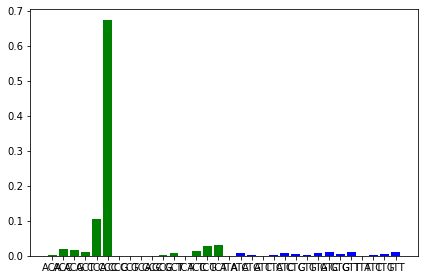

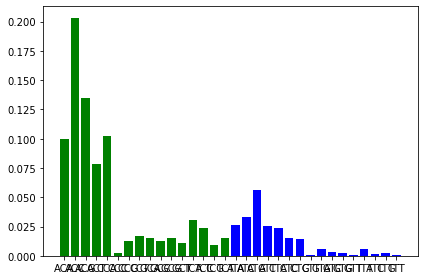

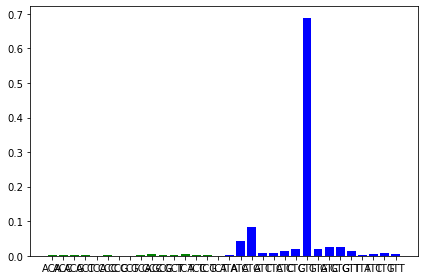

In [29]:
from plotting import *
for j in range(J):
    plot_phi(phi_hat[j])
    plt.tight_layout()
    plt.show()

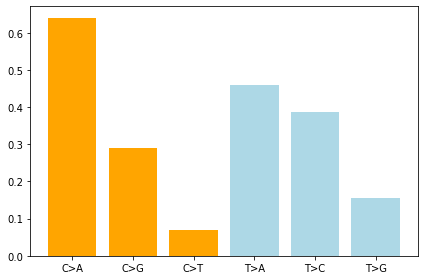

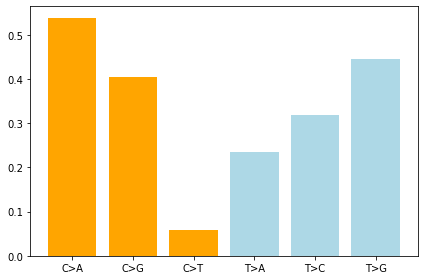

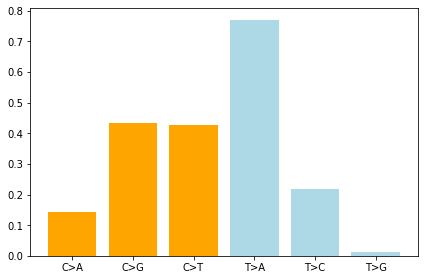

In [30]:
def plot_eta(eta):
    plt.bar(mut6, eta, color = np.repeat(eta_col, 3))
    
for k in range(K):
    plot_eta(eta_hat.reshape(-1, 6)[k])
    plt.tight_layout()
    plt.show()